[0.04696287 0.03980942 0.03228774 0.02568076 0.02559692 0.02475311
 0.02225295 0.02086771 0.01987149 0.0180346  0.01605162 0.01488606
 0.01323728 0.0129047  0.0124786  0.01224979 0.0111334  0.01036508
 0.00966083 0.0095945  0.00955473 0.00836236]
3


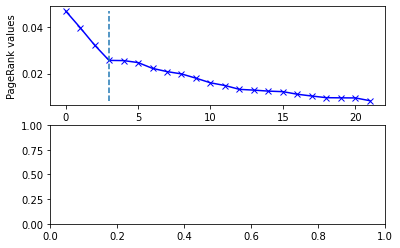

In [1]:
import os
import time
import logging
import yaml
import ast
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from pprgo import utils
from pprgo import ppr
from pprgo import pprgo

import igraph
import pickle

In [2]:
# Set up logging
logger = logging.getLogger()
logger.handlers = []
ch = logging.StreamHandler()
formatter = logging.Formatter(
        fmt='%(asctime)s (%(levelname)s): %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel('INFO')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# !wget --show-progress -O data/reddit.npz https://ndownloader.figshare.com/files/23742119

# Download dataset

# Load config

In [4]:
with open('config_demo.yaml', 'r') as c:
    config = yaml.safe_load(c)

In [5]:
# For strings that yaml doesn't parse (e.g. None)
for key, val in config.items():
    if type(val) is str:
        try:
            config[key] = ast.literal_eval(val)
        except (ValueError, SyntaxError):
            pass

In [6]:
data_file           = config['data_file']           # Path to the .npz data file
data_file = 'data/cora_full.npz'
# data_file = 'data/reddit.npz'

split_seed          = config['split_seed']          # Seed for splitting the dataset into train/val/test
ntrain_div_classes  = config['ntrain_div_classes']  # Number of training nodes divided by number of classes
attr_normalization  = config['attr_normalization']  # Attribute normalization. Not used in the paper

alpha               = config['alpha']               # PPR teleport probability
alpha = 0.25
eps                 = config['eps']                 # Stopping threshold for ACL's ApproximatePR
topk                = config['topk']                # Number of PPR neighbors for each node
topk=64
ppr_normalization   = config['ppr_normalization']   # Adjacency matrix normalization for weighting neighbors

hidden_size         = config['hidden_size']         # Size of the MLP's hidden layer
nlayers             = config['nlayers']             # Number of MLP layers
weight_decay        = config['weight_decay']        # Weight decay used for training the MLP
dropout             = config['dropout']             # Dropout used for training

lr                  = config['lr']                  # Learning rate
max_epochs          = config['max_epochs']          # Maximum number of epochs (exact number if no early stopping)
batch_size          = config['batch_size']          # Batch size for training
batch_mult_val      = config['batch_mult_val']      # Multiplier for validation batch size

eval_step           = config['eval_step']           # Accuracy is evaluated after every this number of steps
run_val             = config['run_val']             # Evaluate accuracy on validation set during training

early_stop          = config['early_stop']          # Use early stopping
patience            = config['patience']            # Patience for early stopping

nprop_inference     = config['nprop_inference']     # Number of propagation steps during inference
inf_fraction        = config['inf_fraction']        # Fraction of nodes for which local predictions are computed during inference

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Load the data

In [8]:
start = time.time()
(adj_matrix, attr_matrix, labels,
 train_idx, val_idx, test_idx) = utils.get_data(
        f"{data_file}",
        seed=split_seed,
        ntrain_div_classes=ntrain_div_classes,
        normalize_attr=attr_normalization
)
try:
    d = attr_matrix.n_columns
except AttributeError:
    d = attr_matrix.shape[1]
nc = labels.max() + 1
print(nc)

print('shape attibute matrix: ', attr_matrix.n_rows)
print('Training: ', len(train_idx))
print('Validation: ', len(val_idx))
print('Testing: ', len(test_idx))

print('train_idx: ', train_idx)

time_loading = time.time() - start
print(f"Runtime: {time_loading:.2f}s")

70
shape attibute matrix:  18800
Training:  1400
Validation:  14000
Testing:  3400
train_idx:  [   12    16    18 ... 18790 18793 18798]
Runtime: 0.39s


# Preprocessing: Calculate PPR scores

In [9]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [10]:
from networkx import from_scipy_sparse_matrix, k_truss, core_number

g_networkX = from_scipy_sparse_matrix(adj_matrix)
# core_numbers = core_number(g_networkX)
# np.save('core-numbers-networkx', np.array(list(core_numbers.values())))


In [11]:
truss = k_truss(g_networkX, 3)
# print(truss.nodes[0:10])

In [12]:
#Compute core numbers
core_numbers = np.load('core-numbers-networkx.npy')

# graph = igraph.Graph.Adjacency((adj_matrix.todense()> 0).tolist())
# core_numbers = np.array(graph.coreness())




In [13]:
# with open('graph.pkl', 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(graph, outp, pickle.HIGHEST_PROTOCOL)

with open('graph.pkl', 'rb') as inp:
    graph = pickle.load(inp)

# shortest_path = graph.get_shortest_paths(0, to=[1,2,3])
# print(shortest_path)

In [14]:
# compute the ppr vectors for train/val nodes using ACL's ApproximatePR

start = time.time()

topk_train, mean_kn = ppr.topk_ppr_matrix(adj_matrix, alpha, eps, train_idx, topk, core_numbers, graph,
                                 normalization=ppr_normalization, S=1, gamma=1.0)
if run_val:
    topk_val = ppr.topk_ppr_matrix(adj_matrix, alpha, eps, val_idx, topk,
                                   normalization=ppr_normalization)
else:
    topk_val = None

time_preprocessing = time.time() - start
print(f"Runtime: {time_preprocessing:.2f}s")


print('topk_train', topk_train.shape)
adj_xd = adj_matrix[train_idx]
print(adj_xd[0:0 + batch_size].shape)

CRE n_best:  922
idx_key_nodes:  (922,)
indptr - 1  18800
nodes with page rank:  [18496, 2537, 91, 12]
For node:  0
j_np:  [13463, 15329, 12809, 111, 14892, 18477, 12487, 13757, 13464, 12681, 4646, 10679, 10332, 5088, 20, 112, 17540, 13893, 15397, 131, 95, 144, 16455, 5779, 14054, 187, 14903, 12690, 139, 71, 15242, 45, 102, 118, 4223, 94, 22, 117, 88, 17541, 4455, 171, 2648, 2649, 18519, 47, 14953, 74, 13131, 11789, 169, 105, 13908, 2152, 18479, 15330, 2474, 98, 77, 113, 16624, 15640, 76, 15388, 2651, 7820, 1872, 3859, 15710, 158, 10963, 12297, 18, 2611, 12374, 4647, 184, 134, 157, 3421, 5237, 4629, 1286, 13339, 1634, 4472, 83, 2557, 40, 18436, 38, 644, 3688, 2650, 4428, 16393, 2643, 185, 7702, 12691, 1789, 520, 4772, 5076, 13742, 107, 4919, 4773, 114, 844, 165, 56, 6570, 13338, 104, 8417, 129, 163, 5071, 127, 192, 149, 14214, 4459, 194, 50, 3404, 10064, 186, 12678, 14859, 4657, 170, 6, 151, 183, 14952, 122, 2287, 175, 13466, 17718, 86, 10331, 46, 78, 167, 4471, 14791, 4624, 3416, 44, 

# Training: Set up model and train

In [15]:
start = time.time()
tf.reset_default_graph()
tf.set_random_seed(0)

model = pprgo.PPRGo(d, nc, hidden_size, nlayers, lr, weight_decay, dropout, adj_matrix, intermediate_layer=1000,
                    sparse_features=type(attr_matrix) is not np.ndarray)

# print(model.w0.shape)

# print(model.w_1.shape)

2022-07-11 11:10:59 (WARNING): From /var/folders/x5/bhlqr68144x_138bllx2mdwh0000gn/T/ipykernel_12244/72873882.py:2: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



2022-07-11 11:10:59 (WARNING): From /var/folders/x5/bhlqr68144x_138bllx2mdwh0000gn/T/ipykernel_12244/72873882.py:3: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



In [16]:
sess = tf.compat.v1.Session()
with sess.as_default():
    tf.compat.v1.global_variables_initializer().run()
    nepochs, loss_hist, acc_hist, f1_hist = pprgo.train(
            sess=sess, model=model, attr_matrix=attr_matrix,
            train_idx=train_idx, val_idx=val_idx,
            topk_train=topk_train, topk_val=topk_val,
            labels=labels, adj_matrix=adj_matrix,
            max_epochs=max_epochs, batch_size=batch_size, batch_mult_val=batch_mult_val,
            eval_step=eval_step, early_stop=early_stop, patience=patience)
time_training = time.time() - start
logging.info('Training done.')
print(f"Runtime: {time_training:.2f}s")

source_idx:  [  0   0   0 ... 511 511 511]
adj_matrix:  (512, 18800)
source_adj:  (3984,)
neighbor_adj:  (3984,)
attr_matrix:  18800 8710
batch_feats:  (95684, 8710)
batch_pprw:  (95684,)
batch_idx:  (95684,)
source_idx:  [  0   0   0 ... 511 511 511]
adj_matrix:  (512, 18800)
source_adj:  (3622,)
neighbor_adj:  (3622,)
attr_matrix:  18800 8710
batch_feats:  (82134, 8710)
batch_pprw:  (82134,)
batch_idx:  (82134,)
source_idx:  [  0   0   0 ... 375 375 375]
adj_matrix:  (376, 18800)
source_adj:  (2659,)
neighbor_adj:  (2659,)
attr_matrix:  18800 8710
batch_feats:  (62535, 8710)
batch_pprw:  (62535,)
batch_idx:  (62535,)


2022-07-11 11:11:06 (INFO): Epoch 6, step 20: train 3.92516
2022-07-11 11:11:10 (INFO): Epoch 13, step 40: train 3.23679
2022-07-11 11:11:14 (INFO): Epoch 19, step 60: train 2.78008
2022-07-11 11:11:18 (INFO): Epoch 26, step 80: train 2.42745
2022-07-11 11:11:23 (INFO): Epoch 33, step 100: train 1.69532
2022-07-11 11:11:27 (INFO): Epoch 39, step 120: train 1.45828
2022-07-11 11:11:30 (INFO): Epoch 46, step 140: train 1.42660
2022-07-11 11:11:34 (INFO): Epoch 53, step 160: train 1.06752
2022-07-11 11:11:39 (INFO): Epoch 59, step 180: train 0.98348


# Inference (val and test)

In [ ]:
start = time.time()
predictions, time_logits, time_propagation = model.predict(
        sess=sess, adj_matrix=adj_matrix, attr_matrix=attr_matrix, alpha=alpha,
        nprop=nprop_inference, inf_fraction=inf_fraction,
        ppr_normalization=ppr_normalization)
time_inference = time.time() - start
print(f"Runtime: {time_inference:.2f}s")

# Collect and print results

In [ ]:

acc_train = 100 * accuracy_score(labels[train_idx], predictions[train_idx])
acc_val = 100 * accuracy_score(labels[val_idx], predictions[val_idx])
acc_test = 100 * accuracy_score(labels[test_idx], predictions[test_idx])

f1_train = f1_score(labels[train_idx], predictions[train_idx], average='macro')
f1_val = f1_score(labels[val_idx], predictions[val_idx], average='macro')
f1_test = f1_score(labels[test_idx], predictions[test_idx], average='macro')



#gpu_max_bytes = tf.contrib.memory_stats.MaxBytesInUse()
#gpu_memory = sess.run(gpu_max_bytes)
memory = utils.get_max_memory_bytes()

time_total = time_preprocessing + time_training + time_inference

In [ ]:
print(f'''
Accuracy: Train: {acc_train:.1f}%, val: {acc_val:.1f}%, test: {acc_test:.1f}%
F1 score: Train: {f1_train:.3f}, val: {f1_val:.3f}, test: {f1_test:.3f}

Runtime: Preprocessing: {time_preprocessing:.2f}s, training: {time_training:.2f}s, inference: {time_inference:.2f}s -> total: {time_total:.2f}s
Memory: Main: {(memory/1024) / 2**30:.2f}GB
''')

#Memory: Main: {memory / 2**30:.2f}GB, GPU: {gpu_memory / 2**30:.3f}GB